# Cómputo Cuántico en la nube

## 1. Configuración

Se debe contar con las siguientes bibliotecas: 
```shell 
pip install matplotlib pylatexenc 
pip install qiskit qiskit-ibm-provider qiskit-ibm-runtime qiskit-aer 
``` 

In [ ]:
!pip install matplotlib pylatexenc 
!pip install qiskit qiskit-ibm-provider qiskit-ibm-runtime qiskit-aer 

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import qasm2
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler
from qiskit_ibm_provider import IBMProvider, least_busy
import numpy  as np
import math

/tmp/ipykernel_7165/2397736641.py:7: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider, least_busy


In [2]:
# Argumentos para los diagramas
draw_kwargs = {
        "output": "mpl",        # matplotlib
        "cregbundle": False,    # separa los cables
        "initial_state": True,  # muestra |0>
        "idle_wires": False,    # no mostar cables sin utilizar
    "style": {
        "subfontsize": 9,       # tamaño
        "dpi": 600
    }
}

Crear una cuenta en: [IBM Quantum Platform](https://quantum.ibm.com/). Iniciar sesión en ir a Dashboard. 

Copiar el API Token

Si es la primera vez que se ejecuta las siguientes líneas, el token se guarda en el disco duro en la dirección **$HOME/.qiskit/qiskit-ibm.json**. 

Solo debe ejecutarse una vez **QiskitRuntimeService.save_account()** para que se guarde el token. 

In [ ]:
API_token = ""
QiskitRuntimeService.save_account(channel="ibm_quantum", token=API_token, overwrite=True)

Verificar que se tenga acceso a los servidores

In [4]:
provider = IBMProvider()

## 2. Compuertas y Circuitos Cuánticos

Para visualizar la acción de las compuertas cuánticas es conveniente utilizar un simulador de la 
esfera de Bloch [Bloch Sphere Simulator](https://bloch.kherb.io/).
Los circuitos cuánticos puede ser construidos interactivamente con la herramienta de IBM
[IBM Quantum Composer](https://quantum.ibm.com/composer).

### 2.1 Circuitos de 1 qubit

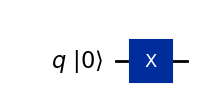

In [5]:
# Se inicia definiendo a los registros. Un registro cuántico como 
# q y un registro clásico como meas.
qreg_q = QuantumRegister(1, "q")
creg_c = ClassicalRegister(1, "meas")

# Creación de un circuito
qc = QuantumCircuit(qreg_q, creg_c)

# Compuerta X
qc.x(qreg_q[0])
qc.draw(**draw_kwargs)

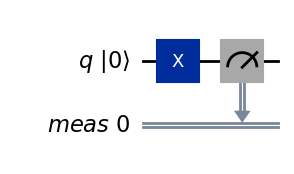

In [6]:
qc.measure(qreg_q[0], creg_c[0])
qc.draw(**draw_kwargs)

### 2.2 Simulación

In [7]:
simulator = AerSimulator()
result = simulator.run(qc, shots = 64).result()
counts = result.get_counts(0)
print(counts)

{'1': 64}


In [8]:
print(qasm2.dumps(qc))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg meas[1];
x q[0];
measure q[0] -> meas[0];


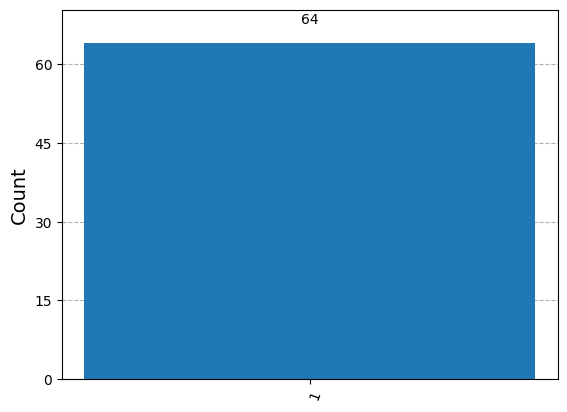

In [9]:
plot_histogram(counts)

### 2.3 Más de 1 qubit
Entrelazamiento cuántico

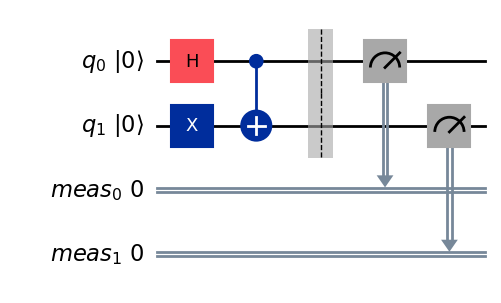

In [17]:
bell = QuantumCircuit(2)
bell.h(0)
bell.x(1)
bell.cx(0, 1)
bell.measure_all()
bell.draw(**draw_kwargs)

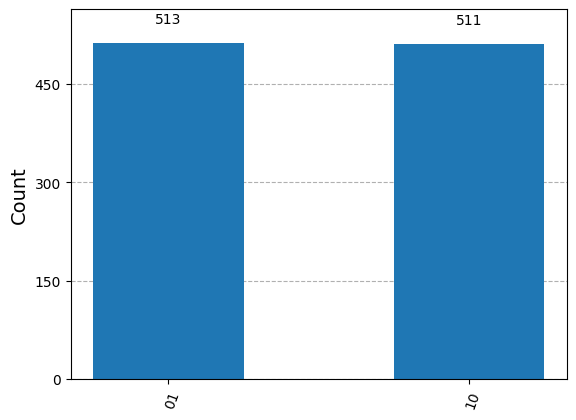

In [19]:
simulator = AerSimulator()
result = simulator.run(bell, shots = 1024).result()
counts = result.get_counts(0)
plot_histogram(counts)

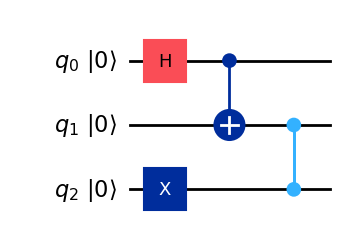

In [20]:
qc = QuantumCircuit(3)

qc.h(0)  
qc.cx(0, 1) 
qc.x(2)
qc.cz(1, 2) 
qc.draw(**draw_kwargs) 

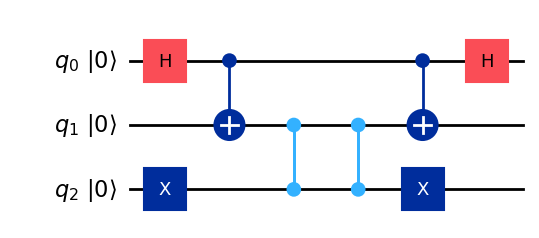

In [21]:
qc.cz(1, 2)
qc.x(2)  
qc.cx(0, 1)  
qc.h(0)
qc.draw(**draw_kwargs)  

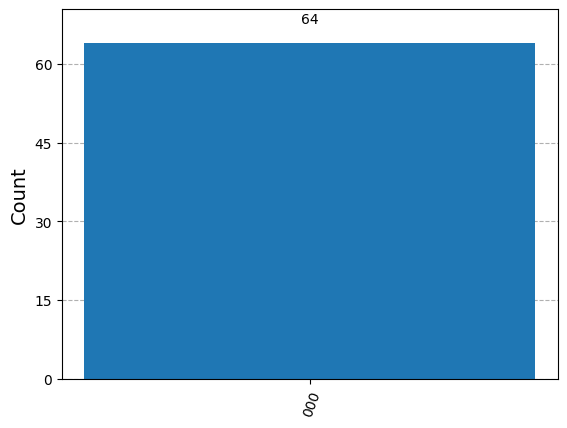

In [22]:
qc.measure_all()
simulator = AerSimulator()
result = simulator.run(qc, shots = 64).result()
counts = result.get_counts(0)
plot_histogram(counts)

## 3. Computación cuántica en la nube

### 3.1 Servidores

In [23]:
provider = IBMProvider()
print("Nombre del sistema           Número de Qubits")
print("---------------------------------------------")
print(provider.backends())
for backend in provider.backends():
    config = backend.configuration()
    print(f"{config.backend_name:22}       {config.n_qubits:>3}")

Nombre del sistema           Número de Qubits
---------------------------------------------
[<IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_brisbane')>]
ibm_sherbrooke               127
ibm_kyiv                     127
ibm_brisbane                 127


### 3.2 Hardware cuántico

In [24]:
device = least_busy(provider.backends(
    filters=lambda x : x.configuration().n_qubits >=3 and
        not x.configuration().simulator
        and x.status().operational == True
))

In [25]:
print(device)

<IBMBackend('ibm_brisbane')>


[Computing resources](https://quantum.ibm.com/services/resources)

In [26]:
base, b = quantum_state = (-math.sqrt(3)/2, complex(0, 1/2))
norm = abs(base)**2 + abs(b)**2
print(norm)

0.9999999999999999


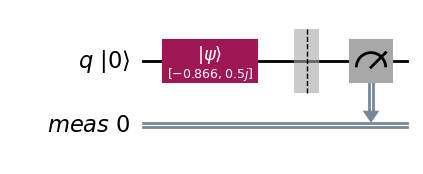

In [27]:
cqc = QuantumCircuit(1)
cqc.initialize(quantum_state, 0)
cqc.measure_all()
cqc.draw(**draw_kwargs)

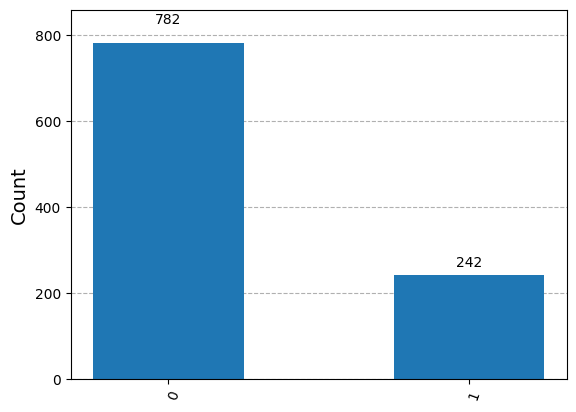

In [28]:
simulator = AerSimulator()
result = simulator.run(cqc, shots = 1024).result() 
counts = result.get_counts(cqc)
plot_histogram(counts)

**Transpilation** es el proceso de rescribir una entrade de un circuito para que coincida con la topología específica de un dispositivo cuántico y/o optimizar la ejecución del circuito en los sistemas cuánticos con ruido. 

Esta operación sigue 6 pasos que pueden ser iterativos: 

- Optimización virtual del circuito 

- Descomposición a compuertas de 3 qubits 

- Posicionamiento de qubits físicos 

- Enrutamiento 

- Traducción a compuertas base 

- Optimización física del circuito 

In [29]:
quantum_hw = provider.get_backend("ibm_sherbrooke")
qc_transpiled = transpile(cqc, quantum_hw)
qc_transpiled.draw(style = "iqd")

global phase: 3π/2
                        ┌───────────┐┌────┐┌──────────┐┌────┐┌──────────┐ ░ ┌─┐
          q_0 -> 0 ─|0>─┤ Rz(-3π/2) ├┤ √X ├┤ Rz(4π/3) ├┤ √X ├┤ Rz(5π/2) ├─░─┤M├
                        └───────────┘└────┘└──────────┘└────┘└──────────┘ ░ └╥┘
    ancilla_0 -> 1 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_1 -> 2 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_2 -> 3 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_3 -> 4 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_4 -> 5 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_5 -> 6 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_6 -> 7 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_7 -> 8 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_8 -> 9 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
   ancilla_9 -> 10 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_10 -> 11 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_11 -> 12 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_12 -> 13 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_13 -> 14 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_14 -> 15 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_15 -> 16 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_16 -> 17 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_17 -> 18 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_18 -> 19 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_19 -> 20 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_20 -> 21 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_21 -> 22 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_22 -> 23 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_23 -> 24 ──────────────────────────────────────────

### 3.3 Ejecución en la nube

In [30]:
job = quantum_hw.run(qc_transpiled, shots=1024)

In [31]:
service = QiskitRuntimeService()
job = service.job('cw9h70mggr6g0087szxg')
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [32]:
data = job.result().data()
countshw = data['counts']
bin_dict = {bin(int(key, 16))[2:].zfill(1): value for key, value in countshw.items()}

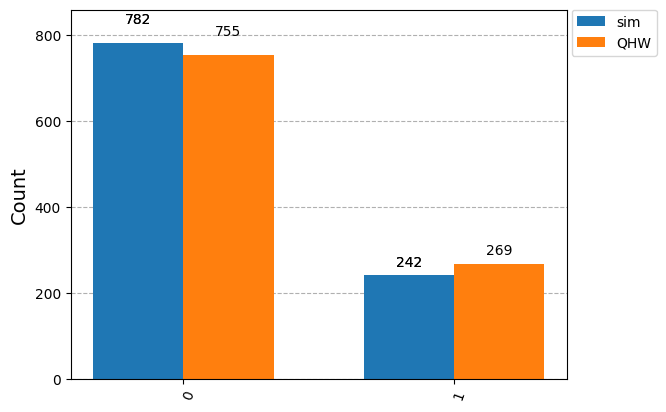

In [33]:
plot_histogram([counts, bin_dict], legend=["sim", "QHW"])

## 4. Algoritmo de Shor

In [34]:
def c_amod15(base, power):
    if base not in [2,4,7,8,11,13]:
        raise ValueError("'a' tiene que ser 2,4,7,8,11 o 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if base in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if base in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if base in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if base in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{base}^{power} mod 15"
    c_U = U.control()
    return c_U

In [35]:
def QFTi(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for k in range(j):
            if k != j:
                qc.cu(-np.pi/float(2**(j-k)), 0, 0, 0, k, j)
        qc.h(j)
    qc.name = "QFTi"
    return qc

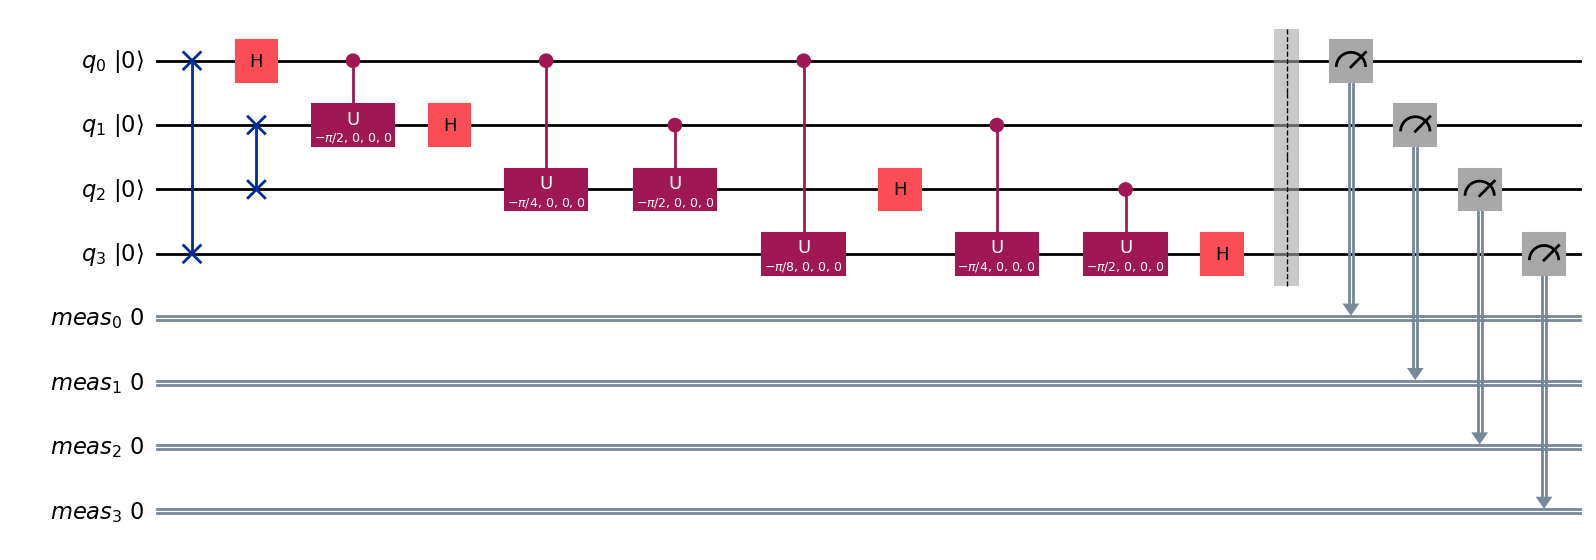

In [36]:
qc = QFTi(4)
qc.measure_all()
qc.draw(**draw_kwargs)

In [37]:
def Shor_15(n_qubits,base):
    qc = QuantumCircuit(n_qubits*2, n_qubits)
    for q in range(n_qubits):
        qc.h(q)
    qc.x(n_qubits)

    for q in range(n_qubits):
        qc.append(c_amod15(base, 2**q),
                 [q] + [i+n_qubits for i in range(4)])
    qc.append(QFTi(n_qubits), range(n_qubits))
    qc.measure(range(n_qubits), range(n_qubits))
    return qc



### 4.1 Factorización 15 con base 7

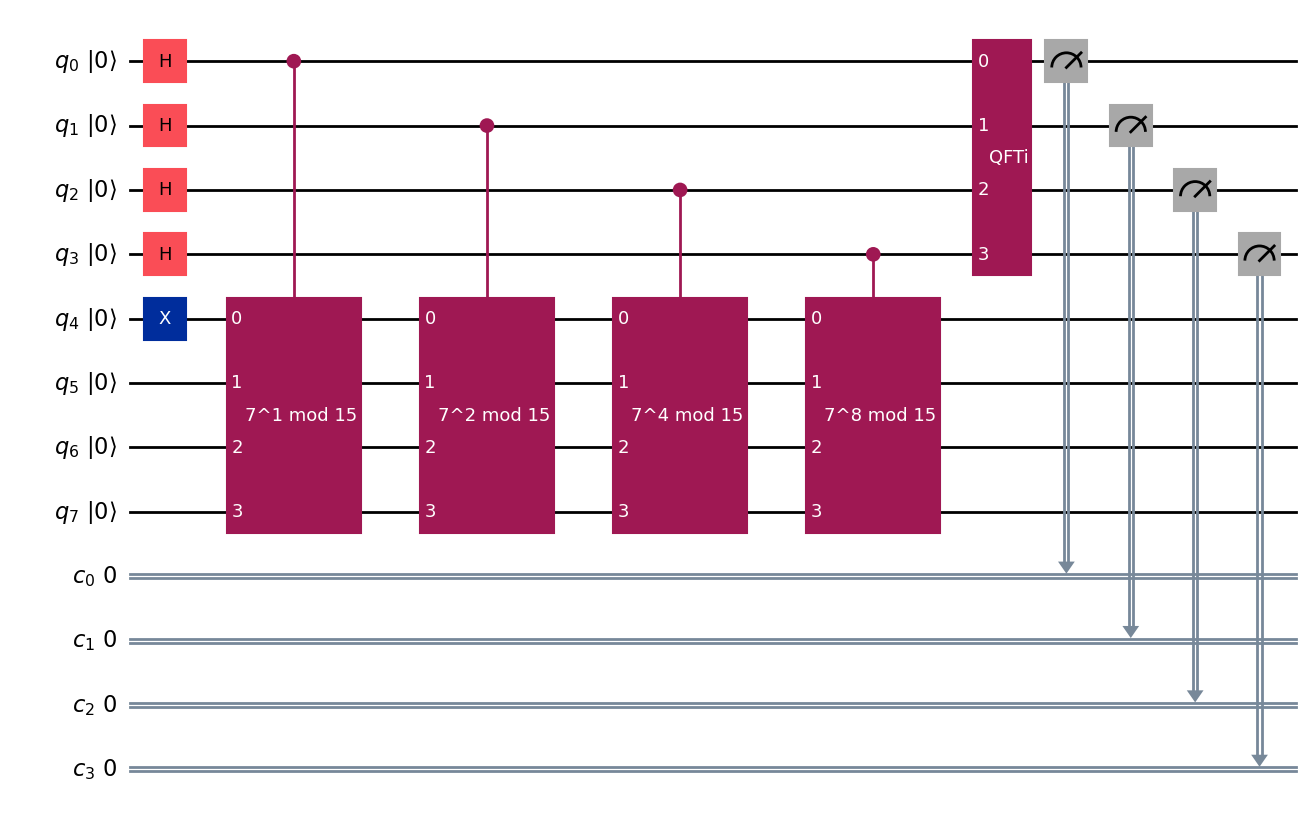

In [38]:

qc = Shor_15(4,7)
qc.draw(**draw_kwargs)

In [40]:

qc_dec_7 = qc.decompose()

Resultados: {'0100': 267, '0000': 273, '1000': 235, '1100': 249}


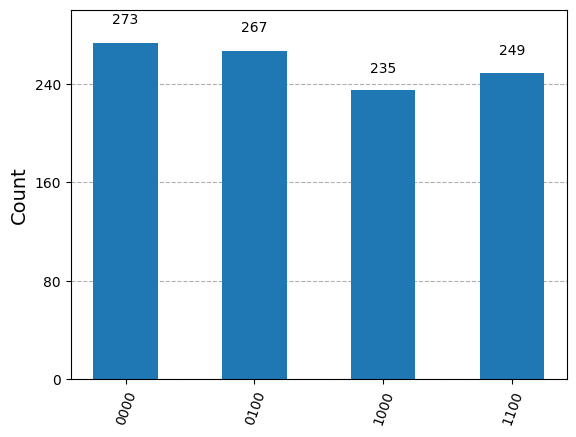

In [41]:
simulator = AerSimulator()
result = simulator.run(qc_dec_7, shots=1024).result()
counts_base7 = result.get_counts(0)
print("Resultados:", counts_base7)
plot_histogram(counts_base7)

In [42]:
from fractions import Fraction

In [43]:
frac = Fraction(12/16)
print(frac)
period = frac.denominator

3/4


In [44]:
def gcd(a, b):
    while b != 0:
        tmp = a % b
        a = b
        b = tmp
    return a

In [45]:
N = 15
base = 7
print("base: ", base, "N: ", N, "period: ", period)
print("factor: ",gcd(base**(period//2) +1, N))
print("factor: ",gcd(base**(period//2) -1, N))

base:  7 N:  15 period:  4
factor:  5
factor:  3


### 4.2 Factorización 15 con base 4

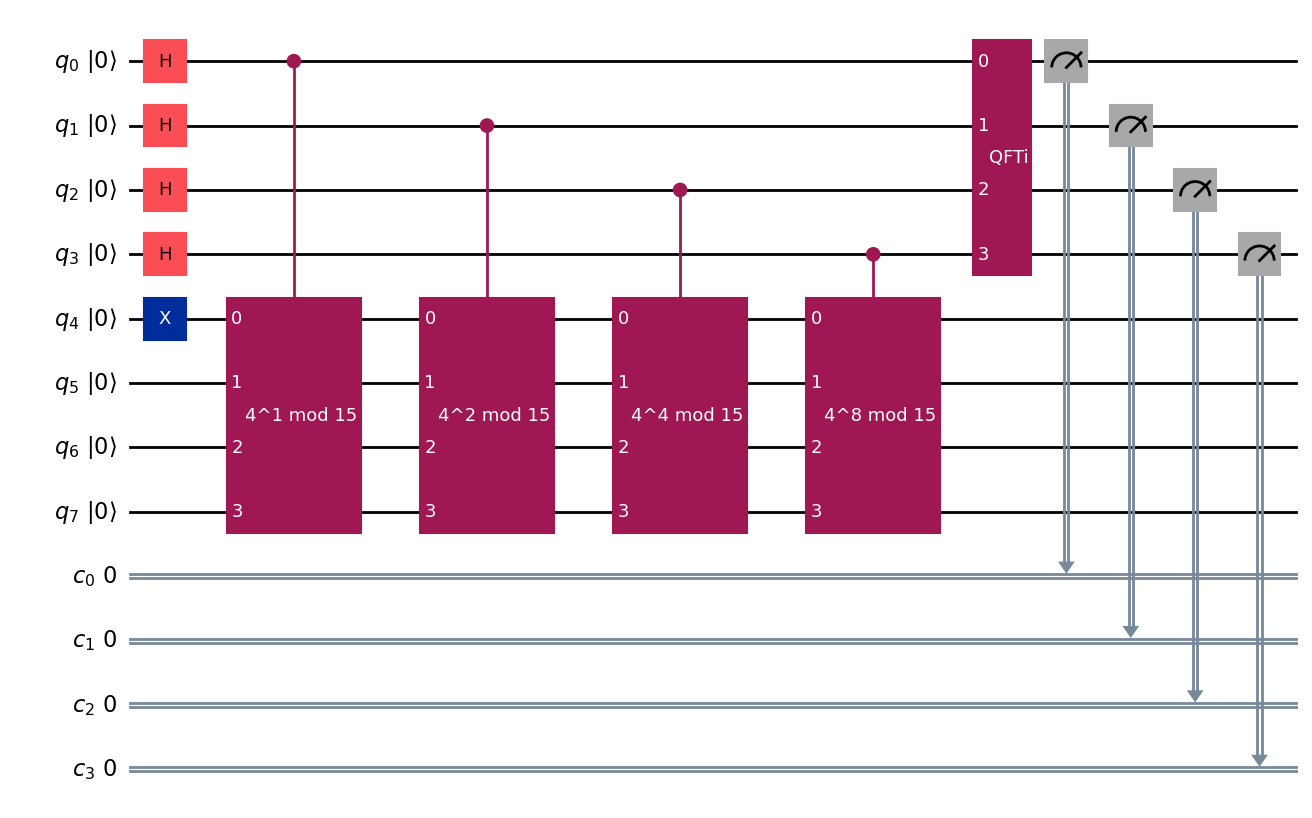

In [46]:

qc = Shor_15(4,4)
qc.draw(**draw_kwargs)

In [47]:

qc_dec_4 = qc.decompose()
# qc_dec.draw(**draw_kwargs)

Resultados: {'1000': 480, '0000': 544}


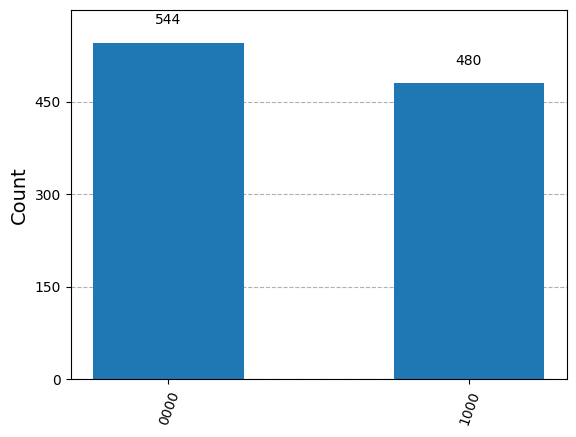

In [48]:
simulator = AerSimulator()
result = simulator.run(qc_dec_4, shots=1024).result()
counts_base4 = result.get_counts(0)
print("Resultados:", counts_base4)
plot_histogram(counts_base4)

In [49]:
frac = Fraction(8/16)
print(frac)
period = frac.denominator

1/2


In [50]:
N = 15
base = 4
print("base: ", base, "N: ", N, "period: ", period)
print("factor: ",gcd(base**(period//2) +1, N))
print("factor: ",gcd(base**(period//2) -1, N))

base:  4 N:  15 period:  2
factor:  5
factor:  3


### 4.3 Shor en hardware cuántico

In [ ]:
provider = IBMProvider()
print("Nombre del sistema           Número de Qubits")
print("---------------------------------------------")
print(provider.backends())
for backend in provider.backends():
    config = backend.configuration()
    print(f"{config.backend_name:22}       {config.n_qubits:>3}")

In [ ]:
device = least_busy(provider.backends(
    filters=lambda x : x.configuration().n_qubits >=3 and
        not x.configuration().simulator
        and x.status().operational == True
))
print(device)

In [54]:
quantum_hw = provider.get_backend("ibm_brisbane")
qc_transpiled = transpile(qc_dec_7, quantum_hw)
# qc_transpiled = transpile(qc_dec_4, quantum_hw)

In [ ]:
qc_transpiled.draw(style = "iqd")

In [55]:
job = quantum_hw.run(qc_transpiled, shots=1024)

In [ ]:
job.job_id()

In [ ]:
job.status()

In [ ]:
job_result = job.result()  # bloquea hasta que se haya completado el trabajo
print("El trabajo termino con un estado: {}".format(job_result))

### 4.2 Base 4

ID del resultado de Shor para factorizar 15 con base 4  con 1024 intentos: 'cvyn6es6xzjg0084hkag'

In [51]:
service = QiskitRuntimeService()
job = service.job('cvyn6es6xzjg0084hkag')
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [52]:
data = job.result().data()
countshw = data['counts']
bin_dict = {bin(int(key, 16))[2:].zfill(4): value for key, value in countshw.items()}

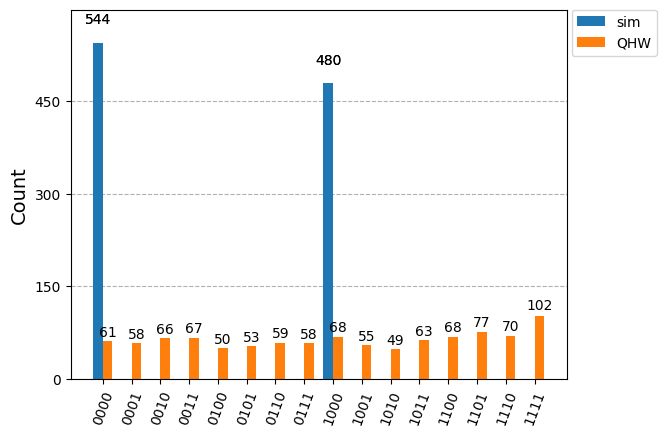

In [53]:
plot_histogram([counts_base4, bin_dict], legend=["sim", "QHW"])

### 4.3 Base 7

ID del resultado de Shor para factorizar 15 con base 4  con 1024 intentos: 'cvynbzzz9es0008e7qy0'

In [54]:
job = service.job('cvynbzzz9es0008e7qy0')
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [55]:
data = job.result().data()
countshw = data['counts']
bin_dict = {bin(int(key, 16))[2:].zfill(4): value for key, value in countshw.items()}

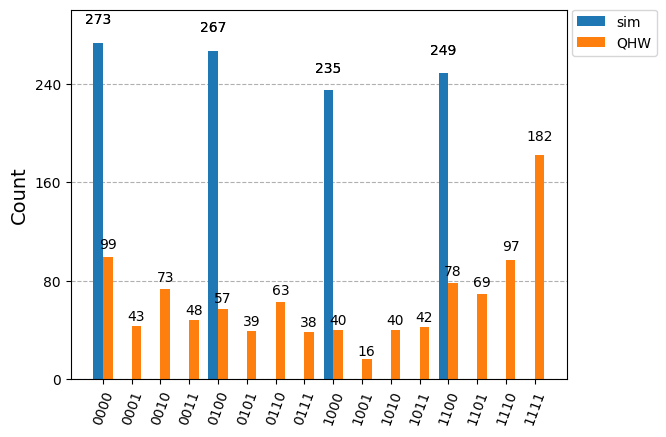

In [56]:
plot_histogram([counts_base7, bin_dict], legend=["sim", "QHW"])

## 5 Sycamore Experiment

In [3]:
qc = QuantumCircuit(3, 3)

# Número de capas de puertas aleatorias
layers = 5

# Añadir puertas aleatorias al circuito
for _ in range(layers):
    # Añadir puertas aleatorias de 1 qubit
    for qubit in range(3):
        angle = np.random.random() * 2 * np.pi
        qc.rx(angle, qubit)  # Rotación en X con ángulo aleatorio
        qc.rz(angle, qubit)  # Rotación en Z con ángulo aleatorio
    
    # Añadir puertas CNOT entre qubits aleatorios
    control, target = np.random.choice(3, 2, replace=False)  # Escoge dos qubits diferentes
    qc.cx(control, target)

# Medir todos los qubits
qc.measure(range(3), range(3))

# Dibujar el circuito
print(qc.draw(output="text"))


     ┌────────────┐┌────────────┐┌───┐ ┌────────────┐ ┌────────────┐»
q_0: ┤ Rx(3.4993) ├┤ Rz(3.4993) ├┤ X ├─┤ Rx(3.8895) ├─┤ Rz(3.8895) ├»
     ├────────────┤├────────────┤└─┬─┘┌┴────────────┤┌┴────────────┤»
q_1: ┤ Rx(4.5293) ├┤ Rz(4.5293) ├──┼──┤ Rx(0.82436) ├┤ Rz(0.82436) ├»
     ├────────────┤├────────────┤  │  └┬────────────┤└┬────────────┤»
q_2: ┤ Rx(1.1803) ├┤ Rz(1.1803) ├──■───┤ Rx(4.7547) ├─┤ Rz(4.7547) ├»
     └────────────┘└────────────┘      └────────────┘ └────────────┘»
c: 3/═══════════════════════════════════════════════════════════════»
                                                                    »
«                   ┌───┐┌────────────┐┌────────────┐    ┌───┐     »
«q_0: ──────────────┤ X ├┤ Rx(1.1015) ├┤ Rz(1.1015) ├────┤ X ├─────»
«     ┌────────────┐└─┬─┘├────────────┤└────────────┘    └─┬─┘     »
«q_1: ┤ Rx(2.6998) ├──┼──┤ Rz(2.6998) ├────────────────────■───────»
«     └────────────┘  │  ├────────────┤┌────────────┐┌────────────┐»
«q_2: ────────────────■──

Resultados: {'100': 10, '000': 148, '010': 64, '001': 34, '101': 294, '110': 123, '011': 240, '111': 111}


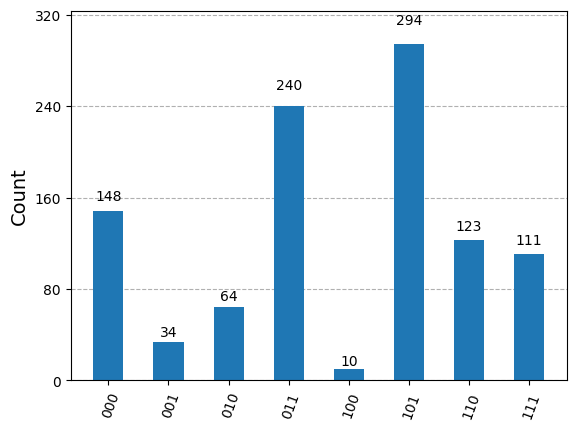

In [4]:
simulator = AerSimulator()
result = simulator.run(qc, shots=1024).result()
counts = result.get_counts(0)
print("Resultados:", counts)
plot_histogram(counts)

In [19]:


# Función para inicializar los valores de entrada
def initialize_inputs(qc, a, b, cin):
    """
    Inicializa los qubits de entrada para el sumador.
    :param qc: QuantumCircuit
    :param a: Valor del bit 'a' (0 o 1)
    :param b: Valor del bit 'b' (0 o 1)
    :param cin: Valor del acarreo de entrada 'cin' (0 o 1)
    """
    if a == 1:
        qc.x(0)  # Qubit a
    if b == 1:
        qc.x(1)  # Qubit b
    if cin == 1:
        qc.x(2)  # Qubit cin
def super_pos(qc):
    qc.h(0)
    qc.h(1)
    qc.h(2)

# Función para construir el sumador completo
def full_adder(qc):
    """
    Implementa un sumador completo en un circuito cuántico.
    :param qc: QuantumCircuit
    """
    # Cálculo del acarreo de salida (cout)
    qc.ccx(0, 1, 4)  # Toffoli para "cout"
    qc.cx(0, 1)      # XOR para la suma parcial (a ⊕ b)
    qc.ccx(2, 3, 4)  # Toffoli para actualizar "cout" basado en cin

    # Cálculo de la suma (sum)
    qc.cx(2, 3)      # XOR para incluir cin en la suma final

# Función principal para construir y simular el sumador
def simulate_full_adder(a, b, cin, super=False):
    """
    Configura, construye y simula el sumador completo para los valores de entrada.
    :param a: Valor del bit 'a' (0 o 1)
    :param b: Valor del bit 'b' (0 o 1)
    :param cin: Valor del acarreo de entrada 'cin' (0 o 1)
    :return: Resultados de la simulación
    """
    # Crear circuito cuántico
    qc = QuantumCircuit(5, 2)

    # Inicializar entradas
    if(super):
        super_pos(qc)
    else:
        initialize_inputs(qc, a, b, cin)

    # Construir el sumador
    full_adder(qc)

    # Medir salidas
    #qc.measure_all()
    qc.measure([3, 4], [0, 1])  # Medimos "sum" y "cout"

    return  qc.decompose()

# Ejemplo: Simulación con entradas a=1, b=0, cin=1
qc = simulate_full_adder(a=1, b=0, cin=0, super=True)


Resultados: {'11': 963, '01': 3011, '00': 2984, '10': 1042}


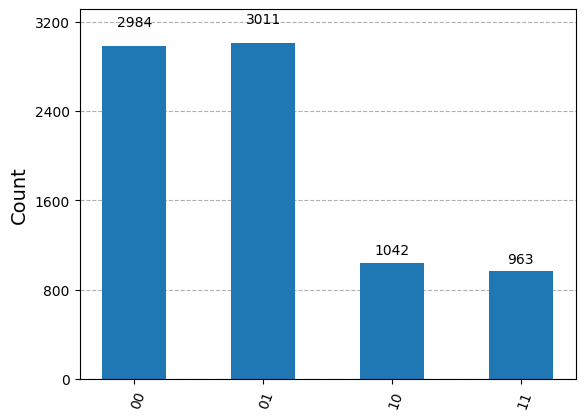

In [21]:
simulator = AerSimulator()
result = simulator.run(qc, shots=8000).result()
counts = result.get_counts(0)
print("Resultados:", counts)
plot_histogram(counts)

| a | b | cin | sum | cout |
|---|---|-----|-----|------|
| 0 | 0 |  0  |  0  |   0  |
| 0 | 0 |  1  |  1  |   0  |
| 0 | 1 |  0  |  1  |   0  |
| 0 | 1 |  1  |  0  |   1  |
| 1 | 0 |  0  |  1  |   0  |
| 1 | 0 |  1  |  0  |   1  |
| 1 | 1 |  0  |  0  |   1  |
| 1 | 1 |  1  |  1  |   1  |


| string | times |
|--------|-------|
|00      |  1   |
|01      |   3  |
|10      |    3 |
|11      |    1 |

Resultados: {'11': 1028, '10': 1052, '00': 3002, '01': 2918}


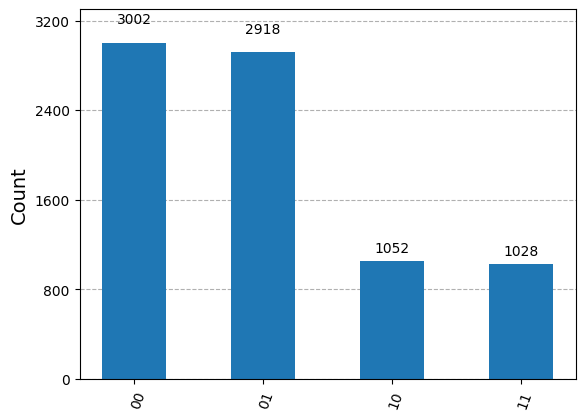

In [22]:
# Crear circuito con 5 qubits (3 entradas + 2 salidas) y 2 bits clásicos
qc = QuantumCircuit(5, 2)

# Aplicar Hadamard a los 3 qubits de entrada
qc.h(0)  # Qubit a
qc.h(1)  # Qubit b
qc.h(2)  # Qubit cin

# Implementar el sumador completo
qc.ccx(0, 1, 4)  # Acarreo de salida (cout)
qc.cx(0, 1)      # XOR parcial (a ⊕ b)
qc.ccx(2, 3, 4)  # Actualizar cout con cin
qc.cx(2, 3)      # Suma final (sum)

# Medir los resultados
qc.measure([3, 4], [0, 1])  # Medir "sum" y "cout"
simulator = AerSimulator()
result = simulator.run(qc, shots=8000).result()
counts = result.get_counts(0)
print("Resultados:", counts)
plot_histogram(counts)

In [52]:

# Función para construir el sumador completo
def carry_sutor(qc, ref_qubit):
    # Cálculo del acarreo de salida (cout)
    qc.ccx(ref_qubit + 1, ref_qubit + 2, ref_qubit + 3)  # Toffoli para "cout"
    qc.cx(ref_qubit + 1, ref_qubit+ 2)      # XOR para la suma parcial (a ⊕ b)
    qc.ccx(ref_qubit, ref_qubit + 2, ref_qubit + 3)  # Toffoli para actualizar "cout" basado en cin

def carry_inv_sutor(qc, ref_qubit):
    # Cálculo del acarreo de salida (cout)
    qc.ccx(ref_qubit, ref_qubit + 2, ref_qubit + 3)  # Toffoli para actualizar "cout" basado en cin
    qc.cx(ref_qubit + 1, ref_qubit+ 2)      # XOR para la suma parcial (a ⊕ b)
    qc.ccx(ref_qubit + 1, ref_qubit + 2, ref_qubit + 3)  # Toffoli para "cout"

def sum_sutor(qc, ref_qubit):
    qc.cx(ref_qubit + 1, ref_qubit+ 2)      # XOR para la suma parcial (a ⊕ b)
    qc.cx(ref_qubit, ref_qubit+ 2)      # XOR para la suma parcial (a ⊕ b)

def initialize_inputs_sutor(qc, a, b, bit_len):
    a_bits = []
    b_bits = []
    for i in range(bit_len):
        a_bits.append((a >> i) & 1)
        b_bits.append((b >> i) & 1)

    for i in range(bit_len):
        if a_bits[i] == 1:
            qc.x(i*3+1)
        if b_bits[i] == 1: 
            qc.x(i*3+2)

def super_pos_sutor(qc, bit_len):
    for i in range(bit_len):
        qc.h(i*3+1)
        qc.h(i*3+2)




# Función principal para construir y simular el sumador
def three_qubit_adder(a, b, super=False):

    qc = QuantumCircuit(10, 4)

    # Inicializar entradas
    if(super):
        super_pos_sutor(qc,3)
    else:
        initialize_inputs_sutor(qc, a, b, 3)

    # Construir el sumador
    carry_sutor(qc,0)
    carry_sutor(qc,3)
    carry_sutor(qc,6)
    qc.cx(7,8)
    sum_sutor(qc,6)
    carry_inv_sutor(qc,3)
    sum_sutor(qc,3)
    carry_inv_sutor(qc,0)
    sum_sutor(qc,0)

    # Medir salidas
    # qc.measure_all()
    qc.measure([2, 5, 8, 9], [0, 1, 2, 3])  # Medimos "sum" y "cout"

    return  qc



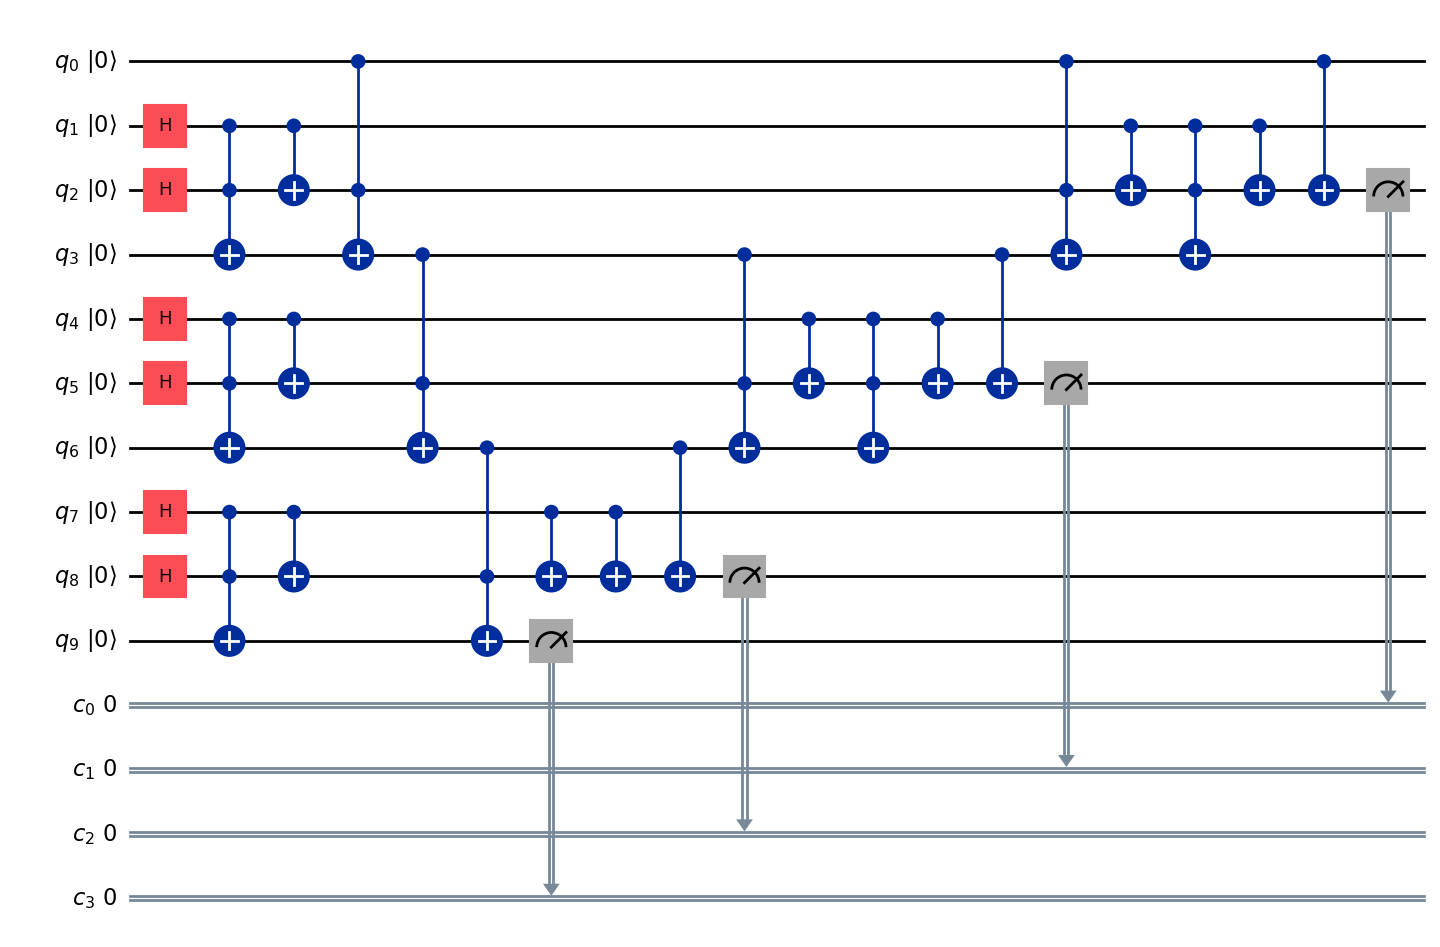

In [53]:
# Ejemplo: Simulación con entradas a=1, b=0, cin=1
qc = three_qubit_adder(a=0, b=0, super=True)
qc.draw(**draw_kwargs)

Resultados: {'0001': 72, '1100': 104, '1010': 182, '0100': 164, '0111': 242, '0011': 131, '1011': 119, '1110': 26, '0101': 169, '1001': 193, '0010': 90, '0000': 26, '1000': 227, '0110': 236, '1101': 67}


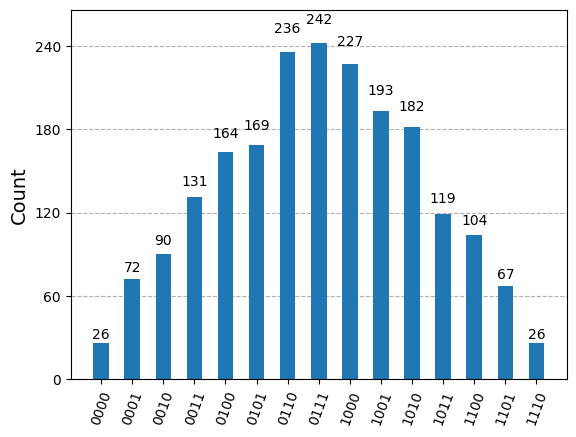

In [54]:
simulator = AerSimulator()
result = simulator.run(qc, shots=2048).result()
counts = result.get_counts(0)
print("Resultados:", counts)
plot_histogram(counts)